# Imports

In [2]:
from google.colab import drive

import os
import time
import ast
import random

import arabic_reshaper
from bidi.algorithm import get_display

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
import chromadb.utils.embedding_functions as embedding_functions
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

import fasttext

from transformers import AutoConfig, AutoTokenizer, AutoModel

import extraction
import prompt

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
SEED = 42
EVALUATION_SET_SIZE = 100
OPENAI_API_KEY = '#############################' # Hidden
COHERE_API_KEY = '#############################' # Hidden

In [27]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

# Evaluation Set

## IMDB Similars

In [6]:
imdb_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/Dataset/validation_dataset.csv')

In [7]:
imdb_df['idf'] = imdb_df['idf'].apply(lambda idf: int(idf[2:]))

In [8]:
imdb_df['similar_movies'] = imdb_df['similar_movies'].apply(lambda x: ast.literal_eval(x))

In [9]:
imdb_df['similar_movies_idf'] = imdb_df['similar_movies'].apply(lambda similar_movies: [int(x[1][2:]) for x in similar_movies])

In [10]:
imdb_evaluation_set = imdb_df.sample(n=EVALUATION_SET_SIZE,
                                     random_state=SEED)

In [11]:
imdb_evaluation_set.head()

,name,idf,name_fa,imdb_score,genres,release,countries,languages,directors,authors,...,actors,summary_kio,summary_digi,summary_tiny,summary_uptv,story,languages_fa,total_summary,similar_movies,similar_movies_idf
525,Lost in Translation,335266,گمشده در ترجمه,7.7,"['درام', 'کمدی']",2003,"['آمریکا', 'ژاپن']","['English', 'Japanese', 'German', 'French']",['Sofia Coppola'],['Sofia Coppola'],...,"['Scarlett Johansson', 'Bill Murray', 'Akiko T...",یک ستاره سینمایی و یک نو عروس افسرده که با هم ...,NaN,NaN,NaN,NaN,"['انگلیسی', 'ژاپنی', 'آلمانی', 'فرانسوی']",یک ستاره سینمایی و یک نو عروس افسرده که با هم ...,"[(Her, tt1798709), (Little Miss Sunshine, tt04...","[1798709, 449059, 467406, 7653254, 159097, 256..."
357,Enemy of the State,120660,دشمن ملت,7.3,"['اکشن', 'هیجان انگیز']",1998,['آمریکا'],['English'],['Tony Scott'],['David Marconi'],...,"['Will Smith', 'Gene Hackman', 'Jon Voight', '...",«رابرت کلیتن دین» (اسمیت)، پدری مهربان، همسری ...,«رابرت کلیتن دین» (اسمیت)، پدری مهربان، همسری ...,NaN,فیلم دشمن حکومت Enemy of the State محصول کشور ...,در فیلم دشمن حکومت : «رابرت کلیتن دین» ، وکیل ...,['انگلیسی'],«رابرت کلیتن دین» (اسمیت)، پدری مهربان، همسری ...,"[(Crimson Tide, tt0112740), (The Rock, tt01175...","[112740, 117500, 453467, 118880, 187078, 11909..."
444,Husbands and Wives,104466,همسران و همسران,7.5,"['درام', 'عاشقانه', 'کمدی']",1992,['آمریکا'],['English'],['Woody Allen'],['Woody Allen'],...,"['Nick Metropolis', 'Woody Allen', 'Mia Farrow...","وقتی ""جک"" و ""سالی"" اعلام می کنند قصد دارند از ...",NaN,NaN,NaN,NaN,['انگلیسی'],"وقتی ""جک"" و ""سالی"" اعلام می کنند قصد دارند از ...","[(Crimes and Misdemeanors, tt0097123), (Manhat...","[97123, 107507, 87003, 118954, 91167, 86637, 8..."
31,Coco,2380307,کوکو,8.4,"['آهنگ', 'انیمیشن', 'خانوادگی', 'رازآلود', 'فا...",2017,['آمریکا'],"['English', 'Spanish']","['Adrian Molina', 'Lee Unkrich']","['Lee Unkrich', 'Jason Katz', 'Matthew Aldrich']",...,"['Anthony Gonzalez', 'Gael García Bernal', 'Be...",پسر بچه ۱۲ ساله ای به نام Miguel که خانواده اش...,کوکو ، یک فیلم انیمیشنی ساخته شده توسط کمپانی ...,NaN,NaN,NaN,"['انگلیسی', 'اسپانیایی']",کوکو ، یک فیلم انیمیشنی ساخته شده توسط کمپانی ...,"[(Inside Out, tt2096673), (Up, tt1049413), (WA...","[2096673, 1049413, 910970, 382932, 198781, 114..."
618,Papillon,70511,پاپیون,8.0,"['بیوگرافی', 'جنایی', 'درام']",1973,"['آمریکا', 'فرانسه']","['English', 'Spanish']",['Franklin J. Schaffner'],"['Dalton Trumbo', 'Lorenzo Semple Jr.', 'Henri...",...,"['Steve McQueen', 'Dustin Hoffman', 'Victor Jo...",«پاپیون» (استیو مک کویین) کسی است که جرم خود ر...,«پاپیون» کسی است که جرم خود را قبول ندارد، به ...,NaN,فیلم Papillon محصول کشور فرانسه و در ژانر بیوگ...,در فیلم پاپیون هنری چاریر یا پاپیون (استیو مک ...,"['انگلیسی', 'اسپانیایی']",«پاپیون» کسی است که جرم خود را قبول ندارد، به ...,"[(Papillon, tt5093026), (Butch Cassidy and the...","[5093026, 64115, 61722, 66999, 62765, 74860, 7..."


## Genre Set

In [12]:
database_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/chromadb/cohere/nlp/final_dataset.csv')

In [13]:
database_df['genres'] = database_df['genres'].apply(lambda x: ast.literal_eval(x))

In [14]:
database_exploded_df = database_df.explode('genres')

In [15]:
genres = database_exploded_df['genres'].dropna().unique()
genres

array(['درام', 'عاشقانه', 'آهنگ', 'مستند', 'ترسناک', 'هیجان انگیز',
       'اکشن', 'کمدی', 'جنایی', 'رازآلود', 'فانتزی', 'ماجراجویی',
       'بیوگرافی', 'انیمیشن', 'کوتاه', 'خانوادگی', 'علمی تخیلی', 'جنگی',
       'موزیکال', 'ورزشی', 'تاریخی', 'وسترن', 'فیلم نوآر',
       'تلویزیون واقع\u200cنما', 'دلهره آور', 'تاک شو', 'اخبار'],
      dtype=object)

In [16]:
random.seed(SEED + 5)
genres_sample = random.sample(list(genres), k=10)
genres_sample

['ماجراجویی',
 'آهنگ',
 'انیمیشن',
 'جنگی',
 'کوتاه',
 'موزیکال',
 'فانتزی',
 'جنایی',
 'علمی تخیلی',
 'بیوگرافی']

# Based on IMDB similars

## Metrics

### IoU:

In [34]:
def imdb_iou(movie_id, similar_movies_retrieved):
    imdb_similar = imdb_evaluation_set[imdb_evaluation_set['idf'] == movie_id]['similar_movies_idf'].tolist()[0]
    if len(imdb_similar) > 0:
        intersection = len(set(similar_movies_retrieved).intersection(set(imdb_similar + [movie_id])))
        union = len(set(similar_movies_retrieved).union(set(imdb_similar)))
        iou = intersection / union
        return iou * 100
    return 0

### Overlap:

In [35]:
def imdb_intersection(movie_id, similar_movies_retrieved):
    imdb_similar = imdb_evaluation_set[imdb_evaluation_set['idf'] == movie_id]['similar_movies_idf'].tolist()[0]
    if len(imdb_similar) > 0:
        intersection = len(set(similar_movies_retrieved).intersection(set(imdb_similar)))
        return intersection
    return 0

## Cohere

In [17]:
cohere_chroma_client = chromadb.PersistentClient(path="/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/chromadb/cohere/nlp")

In [18]:
def create_coolectoin(api_key, chroma_client):
  cohere_ef  = embedding_functions.CohereEmbeddingFunction(api_key=api_key,  model_name="embed-multilingual-v3.0")
  collection = chroma_client.get_or_create_collection(name = "coher", embedding_function=cohere_ef)
  return  collection


In [31]:
cohere_collection = create_coolectoin(COHERE_API_KEY,
                                      cohere_chroma_client)

In [32]:
cohere_results = {}

In [33]:
for _, row in tqdm(imdb_evaluation_set.iterrows(), total=imdb_evaluation_set.shape[0]):
  cohere_results[row['idf']] = [int(x) for x in extraction.search_querY_chroma(collection=cohere_collection,
                                                                                query_text=prompt.create_promt_embeding(row),
                                                                                #  where_meta_data={},
                                                                                n_results=13)]

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


In [36]:
cohere_iou_list = {idf: imdb_iou(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in cohere_results.items()}

In [37]:
cohere_intersection_list = {idf: imdb_intersection(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in cohere_results.items()}

In [38]:
cohere_iou_idf = pd.DataFrame({'idf': cohere_iou_list.keys(),
                               'iou': cohere_iou_list.values(),
                               'intersection': cohere_intersection_list.values()})

## GPT

In [39]:
gpt_embeddings = OpenAIEmbeddingFunction(
    api_key=OPENAI_API_KEY,
    model_name="text-embedding-3-large"
)

In [40]:
gpt_chroma_client = chromadb.PersistentClient(path="/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/chromadb/gpt/nlp")

In [41]:
gpt_collection = gpt_chroma_client.get_or_create_collection(name="open-ai", embedding_function=gpt_embeddings)

In [42]:
gpt_results = {}

In [43]:
for _, row in tqdm(imdb_evaluation_set.iterrows(), total=imdb_evaluation_set.shape[0]):
  gpt_results[row['idf']] = [int(x) for x in extraction.search_querY_chroma(collection=gpt_collection,
                                                                            query_text=prompt.create_promt_embeding(row),
                                                                            #  where_meta_data={},
                                                                            n_results=13)]
  if row['idf'] in gpt_results[row['idf']]:
    gpt_results[row['idf']].remove(row['idf'])

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


In [44]:
gpt_iou_list = {idf: imdb_iou(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in gpt_results.items()}

In [45]:
gpt_intersection_list = {idf: imdb_intersection(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in gpt_results.items()}

In [46]:
gpt_iou_idf = pd.DataFrame({'idf': gpt_iou_list.keys(),
                            'iou': gpt_iou_list.values(),
                            'intersection': gpt_intersection_list.values()})

## FastText

In [47]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
!gunzip /content/cc.fa.300.bin.gz

--2024-03-03 12:19:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.48, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4502524724 (4.2G) [application/octet-stream]
Saving to: ‘cc.fa.300.bin.gz’

cc.fa.300.bin.gz    100%[===================>]   4.19G  41.7MB/s    in 49s     

2024-03-03 12:20:22 (88.3 MB/s) - ‘cc.fa.300.bin.gz’ saved [4502524724/4502524724]



In [48]:
ft_vanilla = fasttext.load_model('cc.fa.300.bin')

In [49]:
ft_finetuned = fasttext.load_model('/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/ft.cc.fa.300.finetuned.bin')

In [50]:
class FasttexEmbeddingtModel(EmbeddingFunction):
    def __init__(self, model):
      self.model = model
    def __call__(self, input: Documents) -> Embeddings:
      result =  [self.model.get_sentence_vector(doc.replace("\n", "") ).tolist() for doc in input]
      return result

In [51]:
fasttext_embedding_function = FasttexEmbeddingtModel(ft_vanilla)

In [52]:
fasttext_chroma_client = chromadb.PersistentClient(path="/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/chromadb/fasttext/nlp")

In [53]:
fasttext_collection = fasttext_chroma_client.get_or_create_collection(name="fasttext", embedding_function=fasttext_embedding_function)

In [54]:
fasttext_results = {}

In [55]:
for _, row in tqdm(imdb_evaluation_set.iterrows(), total=imdb_evaluation_set.shape[0]):
  fasttext_results[row['idf']] = [int(x) for x in extraction.search_querY_chroma(collection=fasttext_collection,
                                                                                  query_text=prompt.create_promt_embeding(row),
                                                                                  #  where_meta_data={},
                                                                                  n_results=13)]

100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


In [56]:
fasttext_iou_list = {idf: imdb_iou(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in fasttext_results.items()}

In [57]:
fasttext_intersection_list = {idf: imdb_intersection(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in fasttext_results.items()}

In [58]:
fasttext_iou_idf = pd.DataFrame({'idf': fasttext_iou_list.keys(),
                                'iou': fasttext_iou_list.values(),
                                'intersection': fasttext_intersection_list.values()})

## ParsBERT

In [59]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("drippypale/parsbert-movie-finetuned")
model = AutoModel.from_pretrained("drippypale/parsbert-movie-finetuned")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/652M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at drippypale/parsbert-movie-finetuned and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
class MyEmbeddingParsBert(EmbeddingFunction):
    def __init__(self, model,tokenizer):
      self.model = model
      self.tokenizer =  tokenizer
    def get_embedding(self,text):
      inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = 512)
      outputs = self.model(**inputs, output_hidden_states=True)
      embedding = outputs.hidden_states[-1][0,0,:]
      return embedding.tolist()

    def __call__(self, input: Documents) -> Embeddings:
        embeddings = [self.get_embedding(doc) for doc in input]
        return embeddings

In [61]:
parsbert_embedding_function = MyEmbeddingParsBert(model, tokenizer)

In [62]:
parsbert_chroma_client = chromadb.PersistentClient(path="/content/gdrive/MyDrive/Colab Notebooks/NLP/Project/chromadb/parsbert/nlp")

In [63]:
parsbert_collection = parsbert_chroma_client.get_or_create_collection(name="bertpersion", embedding_function=parsbert_embedding_function)

In [64]:
parsbert_results = {}

In [65]:
for _, row in tqdm(imdb_evaluation_set.iterrows(), total=imdb_evaluation_set.shape[0]):
  parsbert_results[row['idf']] = [int(x) for x in extraction.search_querY_chroma(collection=parsbert_collection,
                                                                                  query_text=prompt.create_promt_embeding(row),
                                                                                  #  where_meta_data={},
                                                                                  n_results=13)]

100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


In [66]:
parsbert_iou_list = {idf: imdb_iou(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in parsbert_results.items()}

In [67]:
parsbert_intersection_list = {idf: imdb_intersection(idf, similar_movies_retrieved) for idf, similar_movies_retrieved in parsbert_results.items()}

In [68]:
parsbert_iou_idf = pd.DataFrame({'idf': parsbert_iou_list.keys(),
                                'iou': parsbert_iou_list.values(),
                                'intersection': parsbert_intersection_list.values()})

## Plotting

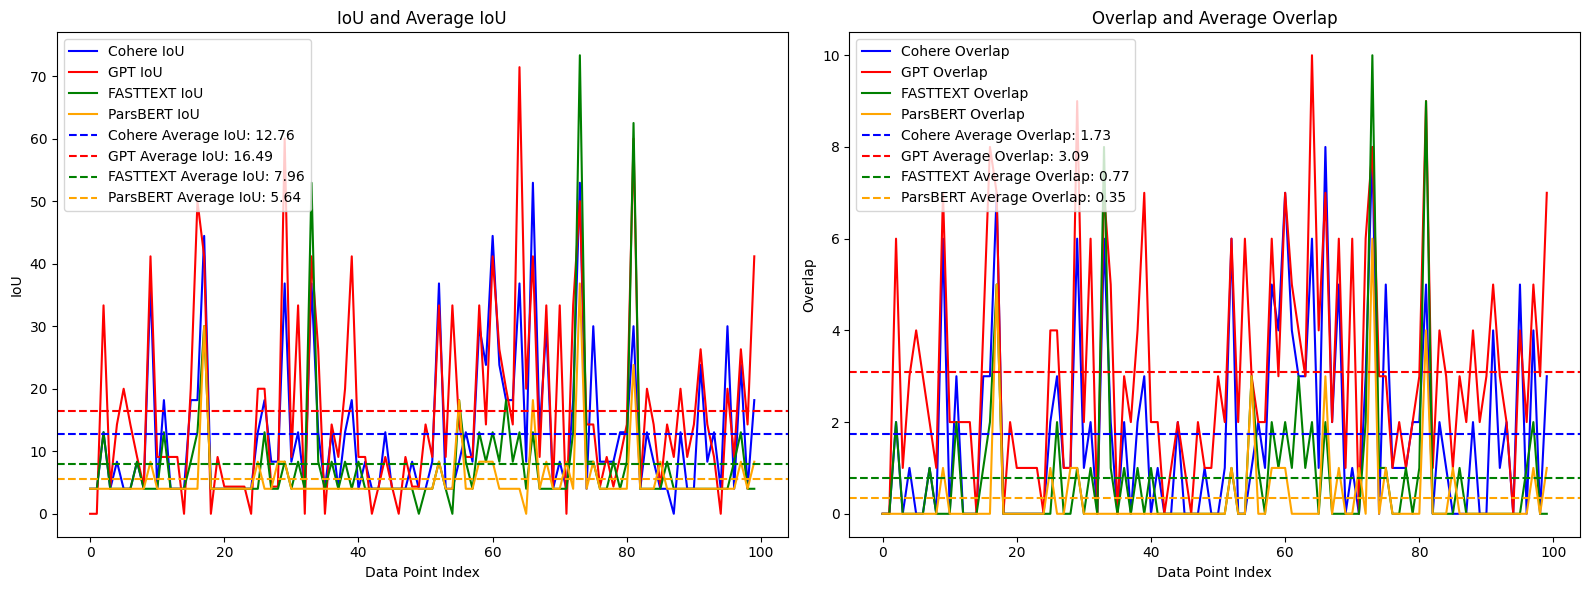

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(cohere_iou_idf['iou'], color='blue', label='Cohere IoU')
axs[0].plot(gpt_iou_idf['iou'], color='red', label='GPT IoU')
axs[0].plot(fasttext_iou_idf['iou'], color='green', label='FASTTEXT IoU')
axs[0].plot(parsbert_iou_idf['iou'], color='orange', label='ParsBERT IoU')

axs[0].axhline(cohere_iou_idf['iou'].mean(), color='blue', linestyle='--', label=f"Cohere Average IoU: {cohere_iou_idf['iou'].mean():.2f}")
axs[0].axhline(gpt_iou_idf['iou'].mean(), color='red', linestyle='--', label=f"GPT Average IoU: {gpt_iou_idf['iou'].mean():.2f}")
axs[0].axhline(fasttext_iou_idf['iou'].mean(), color='green', linestyle='--', label=f"FASTTEXT Average IoU: {fasttext_iou_idf['iou'].mean():.2f}")
axs[0].axhline(parsbert_iou_idf['iou'].mean(), color='orange', linestyle='--', label=f"ParsBERT Average IoU: {parsbert_iou_idf['iou'].mean():.2f}")

axs[0].set_title('IoU and Average IoU')
axs[0].set_xlabel('Data Point Index')
axs[0].set_ylabel('IoU')
axs[0].legend()


axs[1].plot(cohere_iou_idf['intersection'], color='blue', label='Cohere Overlap')
axs[1].plot(gpt_iou_idf['intersection'], color='red', label='GPT Overlap')
axs[1].plot(fasttext_iou_idf['intersection'], color='green', label='FASTTEXT Overlap')
axs[1].plot(parsbert_iou_idf['intersection'], color='orange', label='ParsBERT Overlap')

axs[1].axhline(cohere_iou_idf['intersection'].mean(), color='blue', linestyle='--', label=f"Cohere Average Overlap: {cohere_iou_idf['intersection'].mean():.2f}")
axs[1].axhline(gpt_iou_idf['intersection'].mean(), color='red', linestyle='--', label=f"GPT Average Overlap: {gpt_iou_idf['intersection'].mean():.2f}")
axs[1].axhline(fasttext_iou_idf['intersection'].mean(), color='green', linestyle='--', label=f"FASTTEXT Average Overlap: {fasttext_iou_idf['intersection'].mean():.2f}")
axs[1].axhline(parsbert_iou_idf['intersection'].mean(), color='orange', linestyle='--', label=f"ParsBERT Average Overlap: {parsbert_iou_idf['intersection'].mean():.2f}")

axs[1].set_title('Overlap and Average Overlap')
axs[1].set_xlabel('Data Point Index')
axs[1].set_ylabel('Overlap')
axs[1].legend()


plt.tight_layout()
plt.show()

# Based on genres

In [70]:
def genre_get_prompt(genre):
  prompt = f"""فیلمی را پیدا کنید که این ویژگی ها را برآورده کند :
  ژانر فیلم {genre} است.
      """

  return prompt

## Cohere

In [71]:
cohere_results_genre = {}

In [72]:
for genre in genres_sample:
  genre_results = extraction.search_querY_chroma(collection=cohere_collection,
                                              query_text=genre_get_prompt(genre),
                                              #  where_meta_data={},
                                              n_results=10)
  genre_results = [int(x) for x in genre_results]
  cohere_results_genre[genre] = database_exploded_df.query(f'idf in @genre_results & genres == "{genre}"').drop_duplicates('idf')

In [73]:
rr = {k: (v.shape[0]/10) * 100 for k, v in cohere_results_genre.items()}

In [74]:
cohere_genre_df = pd.DataFrame({'Genre': rr.keys(), 'Accuracy': rr.values()})

## GPT

In [75]:
gpt_results_genre = {}

In [76]:
for genre in genres_sample:
  genre_results = extraction.search_querY_chroma(collection=gpt_collection,
                                                query_text=genre_get_prompt(genre),
                                                #  where_meta_data={},
                                                n_results=10)
  genre_results = [int(x) for x in genre_results]
  gpt_results_genre[genre] = database_exploded_df.query(f'idf in @genre_results & genres == "{genre}"').drop_duplicates('idf')

In [77]:
rr = {k: (v.shape[0]/10) * 100 for k, v in gpt_results_genre.items()}

In [78]:
gpt_genre_df = pd.DataFrame({'Genre': rr.keys(), 'Accuracy': rr.values()})

## FASTTEXT

In [79]:
fasttext_results_genre = {}

In [80]:
for genre in genres_sample:
  genre_results = extraction.search_querY_chroma(collection=fasttext_collection,
                                                query_text=genre_get_prompt(genre),
                                                #  where_meta_data={},
                                                n_results=10)
  genre_results = [int(x) for x in genre_results]
  fasttext_results_genre[genre] = database_exploded_df.query(f'idf in @genre_results & genres == "{genre}"').drop_duplicates('idf')

In [81]:
rr = {k: (v.shape[0]/10) * 100 for k, v in fasttext_results_genre.items()}

In [82]:
fasttext_genre_df = pd.DataFrame({'Genre': rr.keys(), 'Accuracy': rr.values()})

## ParsBERT

In [83]:
parsbert_results_genre = {}

In [84]:
for genre in genres_sample:
  genre_results = extraction.search_querY_chroma(collection=parsbert_collection,
                                                query_text=genre_get_prompt(genre),
                                                #  where_meta_data={},
                                                n_results=10)
  genre_results = [int(x) for x in genre_results]
  parsbert_results_genre[genre] = database_exploded_df.query(f'idf in @genre_results & genres == "{genre}"').drop_duplicates('idf')

In [85]:
rr = {k: (v.shape[0]/10) * 100 for k, v in parsbert_results_genre.items()}

In [86]:
parsbert_genre_df = pd.DataFrame({'Genre': rr.keys(), 'Accuracy': rr.values()})

## Plots

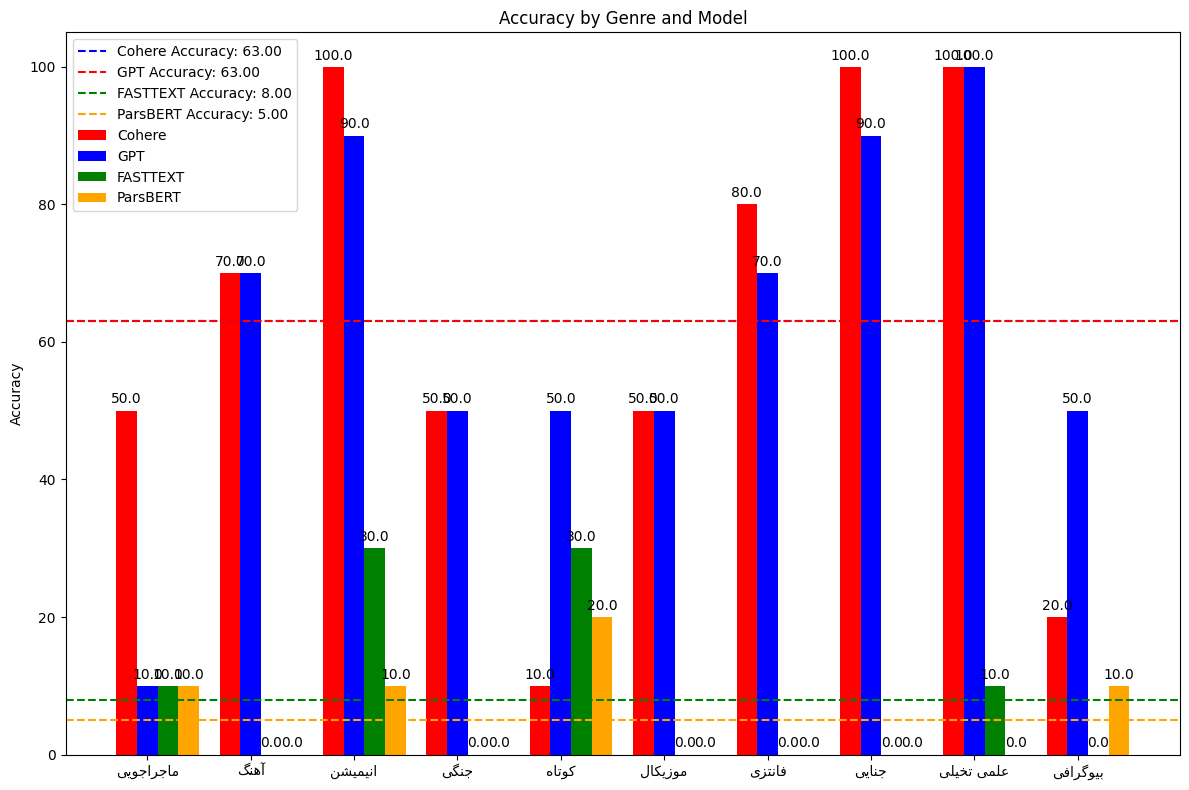

In [87]:
genres = [get_display(arabic_reshaper.reshape(x)) for x in cohere_genre_df['Genre'].unique()]  # Assuming all models have the same genres
x = np.arange(len(genres))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width, cohere_genre_df['Accuracy'], width, label='Cohere', color='red')
rects2 = ax.bar(x, gpt_genre_df['Accuracy'], width, label='GPT', color='blue')
rects3 = ax.bar(x + width, fasttext_genre_df['Accuracy'], width, label='FASTTEXT', color='green')
rects4 = ax.bar(x + width + width, parsbert_genre_df['Accuracy'], width, label='ParsBERT', color='orange')

ax.axhline(cohere_genre_df['Accuracy'].mean(), color='blue', linestyle='--', label=f"Cohere Accuracy: {cohere_genre_df['Accuracy'].mean():.2f}")
ax.axhline(gpt_genre_df['Accuracy'].mean(), color='red', linestyle='--', label=f"GPT Accuracy: {gpt_genre_df['Accuracy'].mean():.2f}")
ax.axhline(fasttext_genre_df['Accuracy'].mean(), color='green', linestyle='--', label=f"FASTTEXT Accuracy: {fasttext_genre_df['Accuracy'].mean():.2f}")
ax.axhline(parsbert_genre_df['Accuracy'].mean(), color='orange', linestyle='--', label=f"ParsBERT Accuracy: {parsbert_genre_df['Accuracy'].mean():.2f}")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Genre and Model')
ax.set_xticks(x)
ax.set_xticklabels(genres)
ax.legend()

# Function to automatically add labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()